# Train a model on CIFAR10 without CudaGraphs

## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

/home/00/dmehlhorn/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


loads images for training and validation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


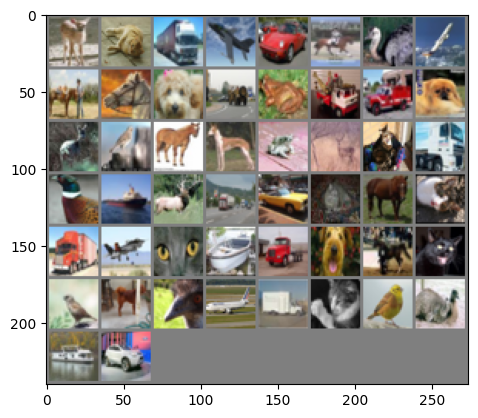

deer  cat   truck plane car   horse bird  plane horse horse dog   truck frog  truck truck dog   deer  bird  horse dog   frog  deer  cat   truck bird  ship  deer  truck car   cat   horse cat   truck plane cat   ship  truck dog   horse cat   bird  dog   bird  plane truck cat   bird  bird  ship  car  


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define CNN

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train

In [5]:
# training
start_time = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=2, active=5, repeat=1)
with torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/training_no_cudagraph_batch{batch_size}'),
    record_shapes=True,
) as prof:
    for epoch in range(2):  # loop over the dataset multiple times
        print(f'epoch {epoch + 1}')
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            torch.cuda.synchronize()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
            
            prof.step()

end_time = time.perf_counter()
print('Finished Training')
print(f'Time: {end_time - start_time:.2f}s')

epoch 1


[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not 

epoch 2
Finished Training
Time: 11.77s


save model

In [6]:
PATH = f'./model/cifar_net{batch_size}.pth'
torch.save(net.state_dict(), PATH)

validate

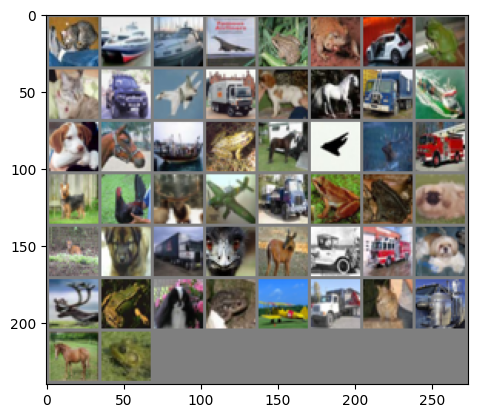

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog 


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

# print shape of output tensor
print(outputs.shape)

Predicted:  cat   ship  ship  ship  frog  frog  cat   frog  dog   ship  plane car   frog  car   truck ship  dog   horse ship  frog  truck plane plane horse bird  car   frog  truck plane frog  frog  horse dog   frog  truck cat   horse ship  truck dog   plane frog  truck frog  ship  ship  frog  car   frog  frog 
torch.Size([50, 10])


performance for whole dataset

In [9]:
correct = 0
total = 0

start_time = time.perf_counter()
# since we're not training, we don't need to calculate the gradients for our outputs
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=2, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/validation_no_cudagraph_batch{batch_size}'),
    record_shapes=True,
) as prof:
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = net(inputs)

        torch.cuda.synchronize()

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        prof.step()

end_time = time.perf_counter()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(f'Time: {end_time - start_time:.2f}s')

STAGE:2024-03-18 14:37:09 1242459:1242459 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-18 14:37:09 1242459:1242459 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-18 14:37:09 1242459:1242459 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Accuracy of the network on the 10000 test images: 29 %
Time: 1.20s
